In [1]:
# IMPORTS
import matplotlib.pyplot as plt
import numpy as np
import glob, os, shutil,random
import tensorflow as tf
import cv2

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
# IMPORTS
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dropout, Dense, BatchNormalization, Input, Lambda, Activation, Conv2D, MaxPooling2D, Reshape, Bidirectional, TimeDistributed, GRU
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, CSVLogger, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [3]:
# DIRECTORIES
DIRECTORY = '../input/mendeley-dataset/Initial_Dataset/'
TRAIN_DIR = os.path.join(DIRECTORY, 'train')
VAL_DIR = os.path.join(DIRECTORY, 'val')
TEST_DIR = os.path.join(DIRECTORY, 'test')


In [4]:
# HYPERPARAMETERS
learning_rate = 0.0001
BATCH_SIZE = 32
IMG_SIZE = (224,224)
INPUT_SHAPE = (224, 224, 3)

In [5]:
# ASSIGNING DATASET TO VARIABLE
TRAIN_IT = image_dataset_from_directory(TRAIN_DIR, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
VAL_IT = image_dataset_from_directory(VAL_DIR, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
TEST_IT = image_dataset_from_directory(TEST_DIR, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 29070 files belonging to 2 classes.
Found 11189 files belonging to 2 classes.
Found 11156 files belonging to 2 classes.


In [6]:
# DATA AUGMENTATION
DATA_AUG = tf.keras.Sequential([ tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.3) ])

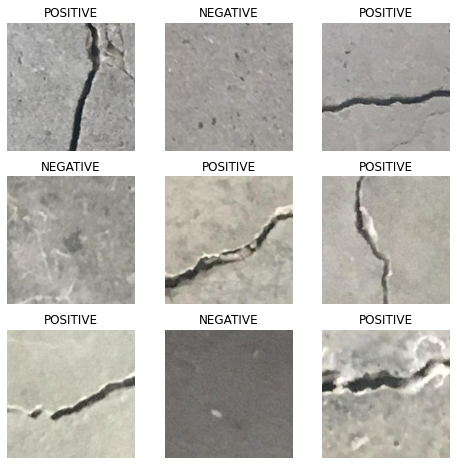

In [7]:
# DATA BEFORE AUGMENTATION
CLASSES = TRAIN_IT.class_names

plt.figure(figsize=(8, 8))
for images, labels in TRAIN_IT.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(CLASSES[labels[i]])
    plt.axis("off")

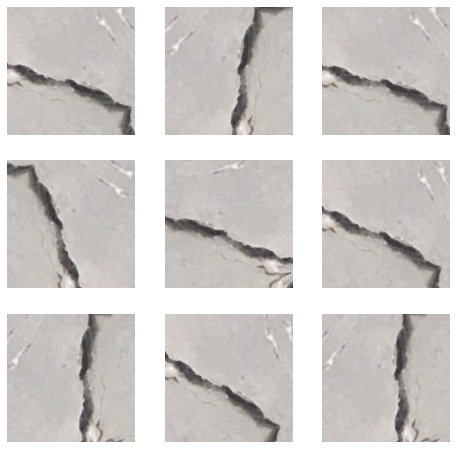

In [8]:
# DATA AFTER AUGMENTATION
for image, _ in TRAIN_IT.take(1):
  plt.figure(figsize=(8, 8))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    aug_img = DATA_AUG(tf.expand_dims(first_image, 0))
    plt.imshow(aug_img[0] / 255)
    plt.axis('off')

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

TRAIN_IT = TRAIN_IT.prefetch(buffer_size=AUTOTUNE)
VAL_IT = VAL_IT.prefetch(buffer_size=AUTOTUNE)
TEST_IT = TEST_IT.prefetch(buffer_size=AUTOTUNE)

In [10]:
INITIAL_MODEL = tf.keras.applications.efficientnet.EfficientNetB0(input_shape= INPUT_SHAPE, include_top=False, weights='imagenet')

16711680/16705208 [==============================] - 0s 0us/step


In [11]:
INITIAL_MODEL.trainable = False

In [12]:
INITIAL_MODEL.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [13]:
pred_layer = tf.keras.layers.Dense(1,activation='sigmoid')

In [14]:
input = tf.keras.Input(shape= INPUT_SHAPE)
x = DATA_AUG(input)
x = tf.keras.applications.efficientnet.preprocess_input(input)
x = INITIAL_MODEL(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D() (x)
x = tf.keras.layers.Dropout(0.3)(x)
output = pred_layer(x)
model = tf.keras.Model(input, output)

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),loss=tf.keras.losses.BinaryCrossentropy(from_logits= False),
              metrics=['accuracy','Precision', 'Recall'])

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
_________________________________________________________________


In [18]:
epochs = 10
history = model.fit(TRAIN_IT, epochs=epochs, validation_data=VAL_IT)

Epoch 1/10
909/909 [==============================] - 162s 165ms/step - loss: 0.4383 - accuracy: 0.8246 - precision: 0.8448 - recall: 0.8504 - val_loss: 0.0933 - val_accuracy: 0.9952 - val_precision: 0.9965 - val_recall: 0.9960
Epoch 2/10
909/909 [==============================] - 110s 121ms/step - loss: 0.0791 - accuracy: 0.9954 - precision: 0.9962 - recall: 0.9960 - val_loss: 0.0430 - val_accuracy: 0.9959 - val_precision: 0.9967 - val_recall: 0.9969
Epoch 3/10
909/909 [==============================] - 97s 106ms/step - loss: 0.0401 - accuracy: 0.9956 - precision: 0.9955 - recall: 0.9971 - val_loss: 0.0272 - val_accuracy: 0.9965 - val_precision: 0.9969 - val_recall: 0.9976
Epoch 4/10
909/909 [==============================] - 95s 104ms/step - loss: 0.0267 - accuracy: 0.9964 - precision: 0.9960 - recall: 0.9978 - val_loss: 0.0197 - val_accuracy: 0.9970 - val_precision: 0.9972 - val_recall: 0.9981
Epoch 5/10
909/909 [==============================] - 62s 68ms/step - loss: 0.0193 - accur

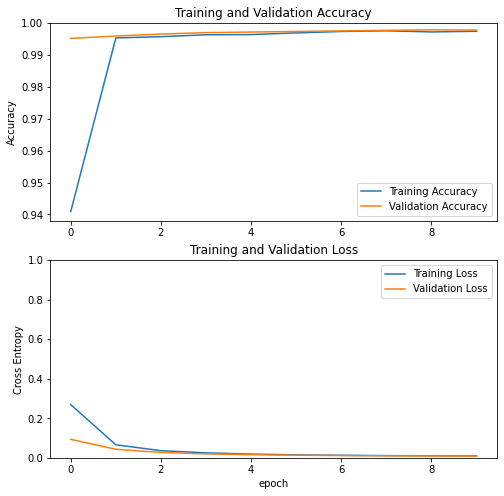

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [20]:
INITIAL_MODEL.trainable = True

In [21]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in INITIAL_MODEL.layers[:fine_tune_at]:
  layer.trainable =  False

In [22]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits= False), optimizer = tf.keras.optimizers.RMSprop(lr=learning_rate/10),
              metrics=['accuracy','Precision','Recall'])

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 4,050,852
Trainable params: 3,841,629
Non-trainable params: 209,223
_________________________________________________________________


In [24]:
fine_tune_epochs = 10
total_epochs =  epochs + fine_tune_epochs

history_fine = model.fit(TRAIN_IT,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=VAL_IT)

Epoch 10/20
909/909 [==============================] - 112s 112ms/step - loss: 0.0050 - accuracy: 0.9986 - precision: 0.9988 - recall: 0.9989 - val_loss: 0.0034 - val_accuracy: 0.9991 - val_precision: 0.9990 - val_recall: 0.9996
Epoch 11/20
909/909 [==============================] - 99s 108ms/step - loss: 0.0031 - accuracy: 0.9993 - precision: 0.9995 - recall: 0.9994 - val_loss: 0.0035 - val_accuracy: 0.9993 - val_precision: 0.9992 - val_recall: 0.9997
Epoch 12/20
909/909 [==============================] - 97s 107ms/step - loss: 0.0026 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9996 - val_loss: 0.0038 - val_accuracy: 0.9991 - val_precision: 0.9989 - val_recall: 0.9997
Epoch 13/20
909/909 [==============================] - 99s 108ms/step - loss: 0.0024 - accuracy: 0.9995 - precision: 0.9997 - recall: 0.9995 - val_loss: 0.0034 - val_accuracy: 0.9995 - val_precision: 0.9994 - val_recall: 0.9997
Epoch 14/20
909/909 [==============================] - 99s 108ms/step - loss: 0.0018 - 

In [25]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

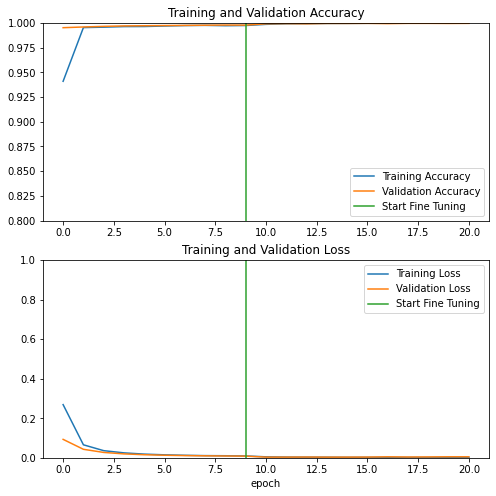

In [26]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([epochs-1,epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([epochs-1,epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [27]:
loss, accuracy, precision, recall = model.evaluate(TEST_IT)
print('Test accuracy :', accuracy)
print('Test precision :', precision)
print('Test recall :', recall)

349/349 [==============================] - 47s 132ms/step - loss: 0.0031 - accuracy: 0.9996 - precision: 0.9994 - recall: 0.9999
Test accuracy : 0.9995518326759338
Test precision : 0.9994412660598755
Test recall : 0.9998602867126465


In [28]:
f1_score = (2*precision*recall)/(precision+recall)
print('F1 Score : ', f1_score)

F1 Score :  0.9996507324763497
